权重衰减（weight decay）是最广泛使用的正则化的技术之一， 它通常也被称为$L_2$正则化。 这项技术通过函数与零的距离来衡量函数的复杂度，

一种简单的方法是通过线性函数 $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$中的权重向量的某个范数来度量其复杂性， 例如$||w||^2$。 要保证权重向量比较小， 最常用方法是将其范数作为惩罚项加到最小化损失的问题中。 将原来的训练目标最小化训练标签上的预测损失， 调整为最小化预测损失和惩罚项之和。 现在，如果我们的权重向量增长的太大， 我们的学习算法可能会更集中于最小化权重范数。

$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2,$

正则化线性模型构成经典的岭回归（ridge regression）算法， 正则化线性回归是统计学中类似的基本模型， 通常被称为套索回归（lasso regression）。 使用$L_2$范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。 这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。 在实践中，这可能使它们对单个变量中的观测误差更为稳定。 相比之下，$L_1$惩罚会导致模型将权重集中在一小部分特征上， 而将其他权重清除为零。 这称为特征选择（feature selection），这可能是其他场景下需要的。

$L_2$正则化回归的小批量随机梯度下降更新如下式

$\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}$

<img src="https://upload-images.jianshu.io/upload_images/2683440-9e19e547cddd234f.jpg?imageMogr2/auto-orient/strip|imageView2/2/w/314/format/webp">

因为η、λ、n都是正的，在样本量充足的时候，1-ηλ/n小于1，它的效果是减小w，这也就是权重衰减的由来

较小的$\lambda$值对应较少约束的w， 而较大的值对w的约束更大。

拿fitting文件中的三次多项式进行实验

In [1]:
import torch
from d2l import torch as d2l
import math
from torch import nn
import random
max_degree = 20
n_train, n_test = 100, 100
true_w = torch.zeros(max_degree)  # 系数向量
true_w[0:4] = torch.tensor([5, 1.2, -3.4, 5.6])  # 确定的系数向量，其余为0
torch.manual_seed(47)  # torch(CPU)设置种子
features = torch.normal(mean=0, std=1.2, size=(n_train + n_test, 1))  # 自变量
# torch的normal要设置mean
# torch 没有现成的shuffle，random.shuffle(features)
poly_features = torch.pow(features, torch.arange(max_degree))  # 得到每个feature的各阶幂行向量组成的矩阵
#numpy为power，torch为pow
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!

labels = poly_features @ true_w  # 获取各个x的标准y值作为数据标签

labels += torch.normal(mean=0, std=0.1, size=(labels.shape))  # 添加噪声
labels.shape,poly_features.shape

(torch.Size([200]), torch.Size([200, 20]))

In [2]:
def train(wd,  num_epochs=1000,lr=0.01):
    loss = (
        nn.MSELoss()
    )  # 使用默认行为(误差均值，backword的时候不用求mean，使用d2l那个函数的时候需要为reduction需要为none)
    input_shape = poly_features.shape[-1]

    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))  # bias已在数据中设置(w0)
    # net[0].weight.data.normal_(0, 0.01) 默认的对此例效果更好(均匀分布)
    batch_size = min(10, poly_features.shape[0])  # batch_size最大值设为10

    #!!记得修改labels的shape为列向量，默认形状是1Dtensor
    train_iter = d2l.load_array(
        (poly_features[:n_train, :], labels[:n_train].reshape(-1, 1)), batch_size
    )
    test_iter = d2l.load_array(
        (poly_features[n_test:, :], labels[n_test:].reshape(-1, 1)),
        batch_size,
        is_train=False,
    )
    trainer = torch.optim.SGD(
        [
            {"params": net[0].weight, "weight_decay": wd},  # 设置衰退系数lambda,不用修改loss，为0时不作用，越大约束越大
        ],
        lr=lr,
    )
    animator = d2l.Animator(
        xlabel="epoch",
        ylabel="loss",
        yscale="log",
        xlim=[1, num_epochs],
        ylim=[1e-3, 1e3],
        legend=["train", "test"],
    )
    for epoch in range(num_epochs):  # 迭代次数(被训练的是同一样本)
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(
                epoch + 1,
                (
                    d2l.evaluate_loss(net, train_iter, loss),
                    d2l.evaluate_loss(net, test_iter, loss),
                ),
            )  # 注意后面的数据要组成元组传入
    print("weight:", net[0].weight.data.numpy())  # 输出权重
    print("true_w:",true_w[0:4])
    
    print("w的L2范数：", net[0].weight.norm().item())


weight: [[ 4.972602    1.2351147  -3.244836    5.2847767  -0.4830251   1.3994575
  -0.07574251 -0.01431806  0.09343842  0.18101776 -0.03022628  0.16449252
   0.1988462   0.08127607 -0.20618509  0.04979612 -0.08572798 -0.00845094
  -0.04454179 -0.14321326]]
true_w: tensor([ 5.0000,  1.2000, -3.4000,  5.6000])
w的L2范数： 8.191359519958496


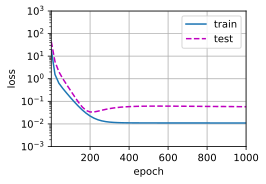

In [3]:
train(0)

weight: [[ 4.8995590e+00  1.3709764e+00 -3.1151173e+00  4.9677958e+00
  -5.4723912e-01  1.2866429e+00 -5.7562340e-02  1.8607308e-01
  -5.1117402e-02  2.8310142e-02 -3.1340636e-02  1.3447211e-02
  -3.3338808e-02  2.2127109e-02 -8.6783851e-03 -5.7908729e-02
   2.4749669e-03  5.6448005e-02  3.6679864e-02  7.5841309e-03]]
true_w: tensor([ 5.0000,  1.2000, -3.4000,  5.6000])
w的L2范数： 7.891467571258545


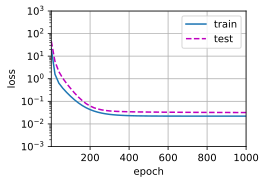

In [4]:
train(0.01)


weight: [[ 4.932676    1.30335    -3.1629071   5.129485   -0.5694473   1.3141749
  -0.01494583  0.21869859 -0.04976067  0.13030115  0.07846308 -0.04877622
   0.10700907  0.10612565  0.00953017  0.12025321 -0.08200553  0.08074829
  -0.0093107   0.00884531]]
true_w: tensor([ 5.0000,  1.2000, -3.4000,  5.6000])
w的L2范数： 8.032661437988281


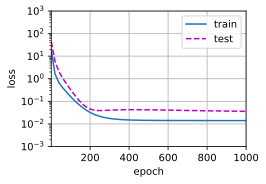

In [5]:
train(0.005)

weight: [[ 4.8330388e+00  1.4858396e+00 -3.0103214e+00  4.6931725e+00
  -5.6733394e-01  1.1929777e+00 -2.5391966e-02  1.5967883e-01
   3.0741416e-02  2.5117151e-02 -2.4620539e-02 -4.7810692e-03
  -1.4843015e-02  3.4860489e-03  9.1323517e-03 -3.7448485e-03
  -1.9090270e-03 -1.6050138e-02 -9.2727691e-04 -1.0753540e-02]]
true_w: tensor([ 5.0000,  1.2000, -3.4000,  5.6000])
w的L2范数： 7.643821716308594


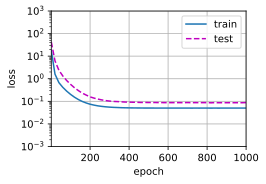

In [6]:
train(0.02)